In [59]:
import pandas
from scipy.optimize import curve_fit
from numpy import exp, sqrt, diag
import matplotlib.pyplot as plt 
from matplotlib import style

In [60]:
def f(x, x0, L, k): return L/(1+exp(-k*(x-x0))) 

def fit( df ):
    if True:
        try:
            p0 = ( 40, rate.max(), -1 )
            popt, pcov = curve_fit( f=f, xdata=df.temp, ydata=df.rate, p0=p0 )
            perr = sqrt( diag( pcov ) )
        except:
            return pandas.Series( { 'tm': None, 'L': None, 'k': None, 
                                    'err_tm': None, 'err_L': None, 'err_k': None } )
        
        return pandas.Series( { 'tm': popt[0], 'L': popt[1], 'k': popt[2], 
                                'err_tm': perr[0], 'err_L': perr[1], 'err_k': perr[2] } )


In [61]:
df = pandas.read_csv( 'data-clean.csv' )
grouped = df.groupby( 'mutant' )
fits = grouped.apply( fit )

# descriptive stats 
fits

,L,err_L,err_k,err_tm,k,tm
mutant,,,,,,
100,NaN,NaN,NaN,NaN,NaN,NaN
101,NaN,NaN,NaN,NaN,NaN,NaN
104,NaN,NaN,NaN,NaN,NaN,NaN
106,NaN,NaN,NaN,NaN,NaN,NaN
113,NaN,NaN,NaN,NaN,NaN,NaN
114,NaN,NaN,NaN,NaN,NaN,NaN
116,NaN,NaN,NaN,NaN,NaN,NaN
117,NaN,NaN,NaN,NaN,NaN,NaN
119,NaN,NaN,NaN,NaN,NaN,NaN


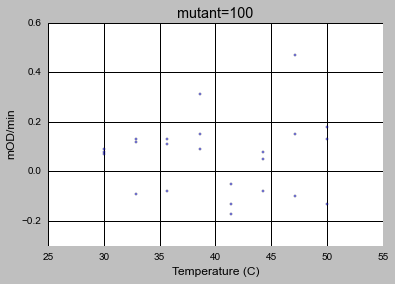

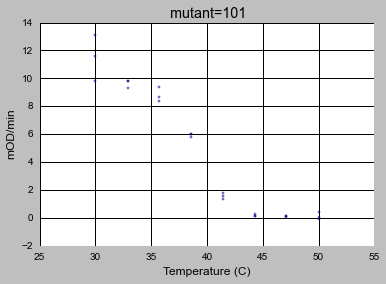

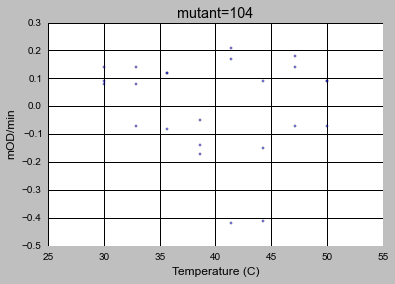

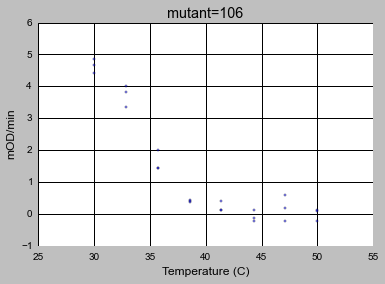

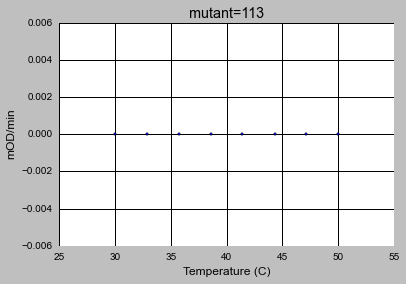

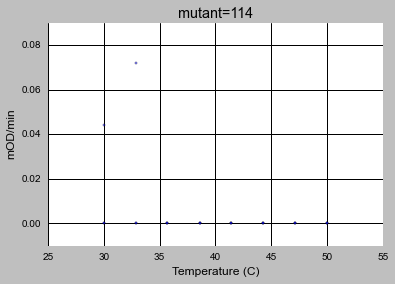

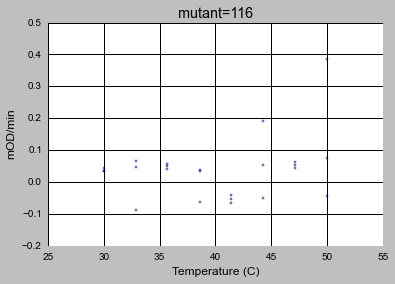

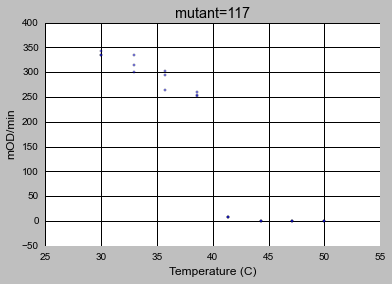

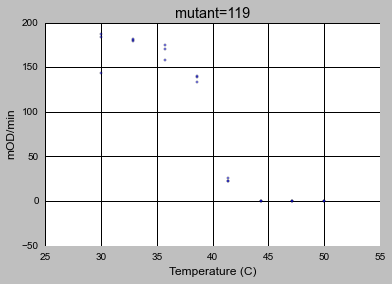

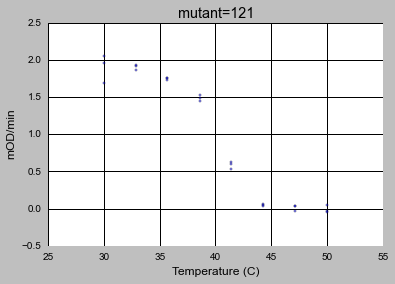

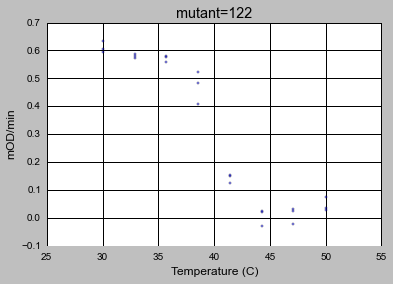

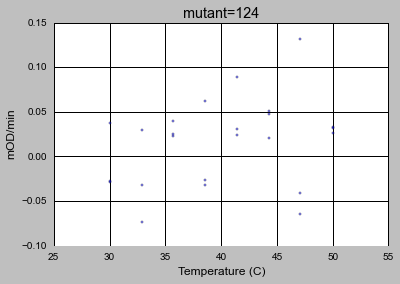

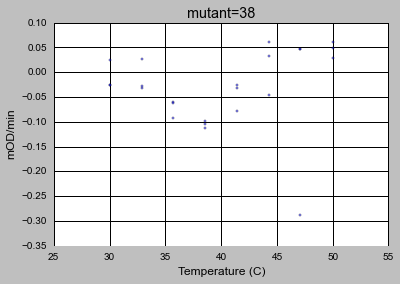

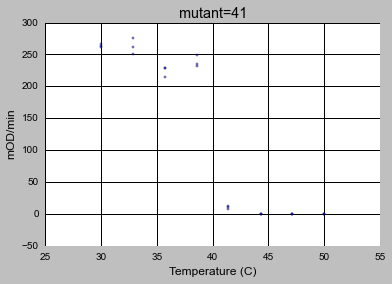

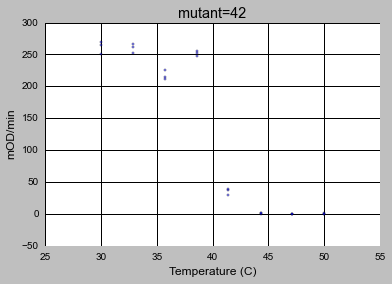

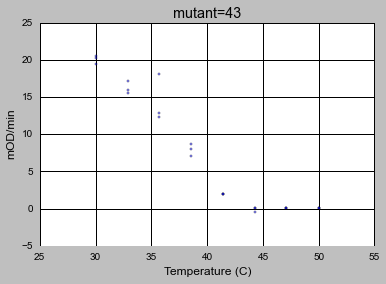

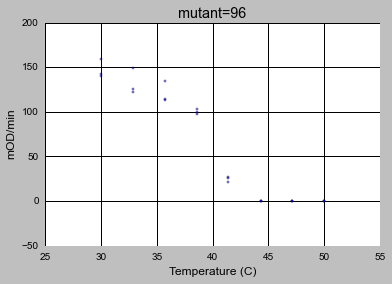

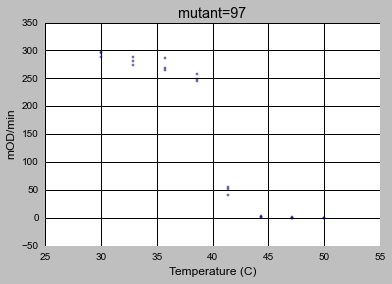

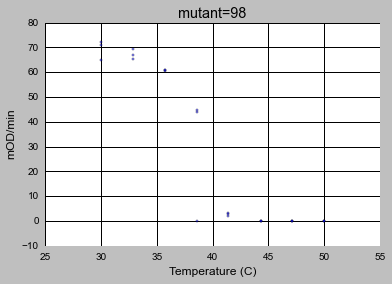

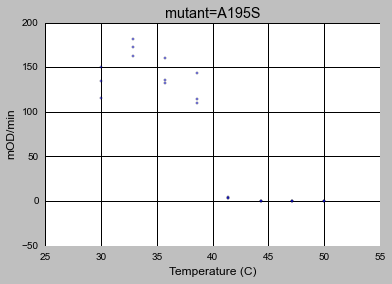

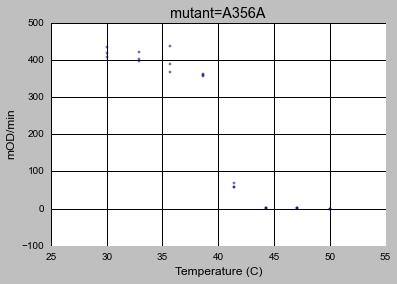

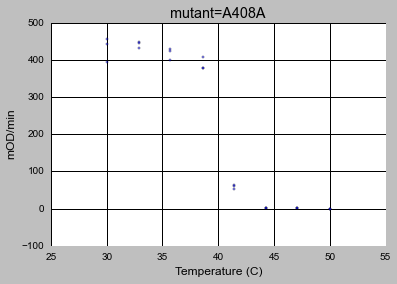

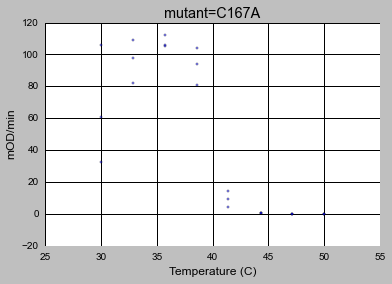

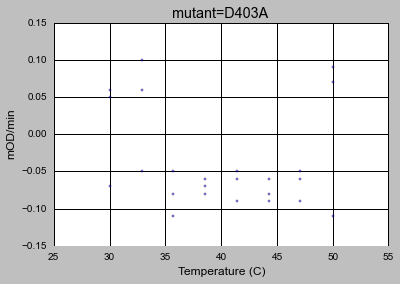

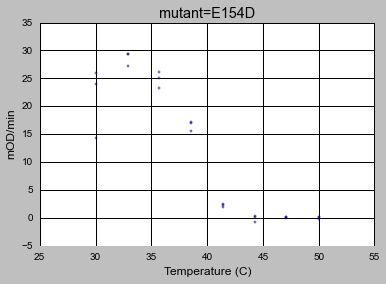

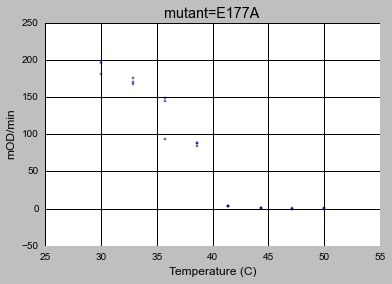

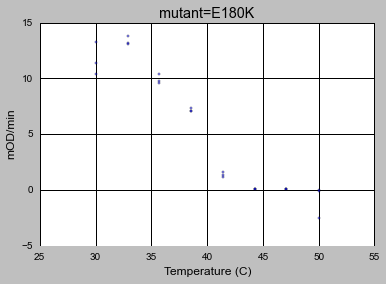

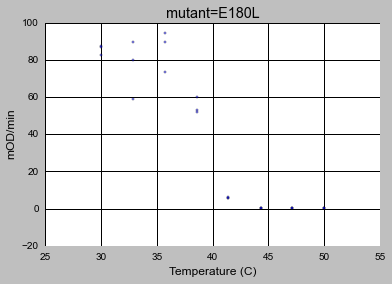

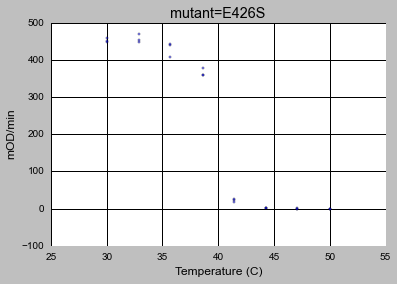

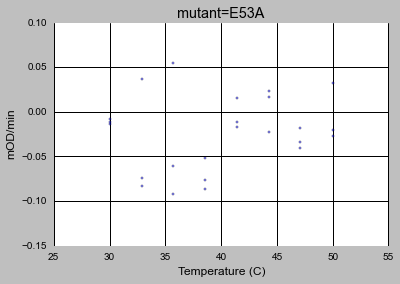

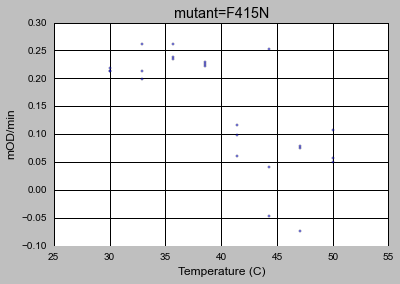

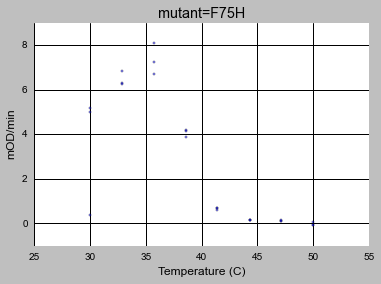

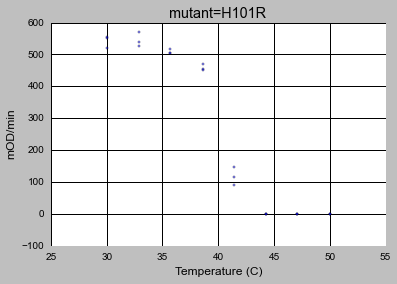

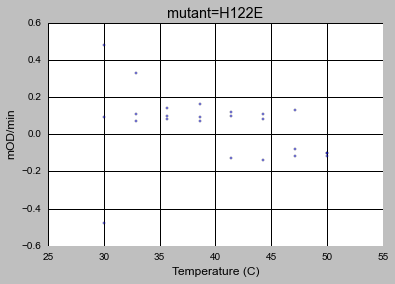

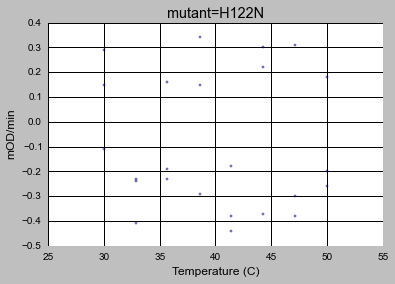

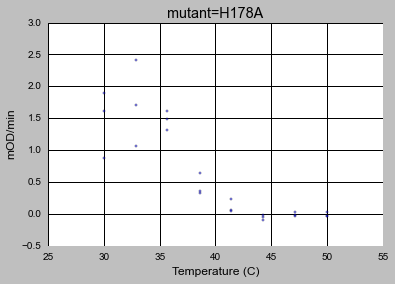

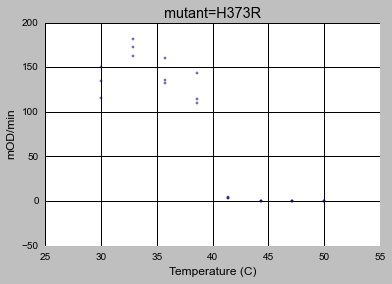

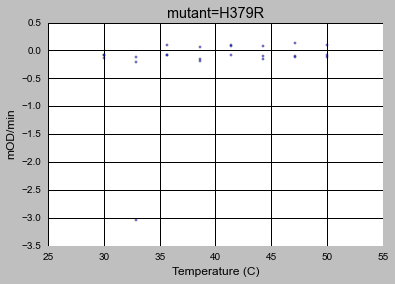

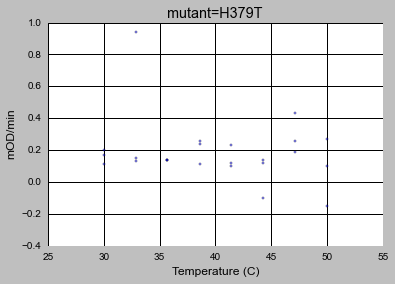

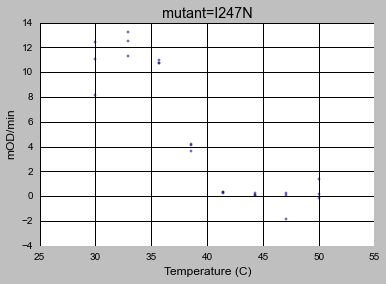

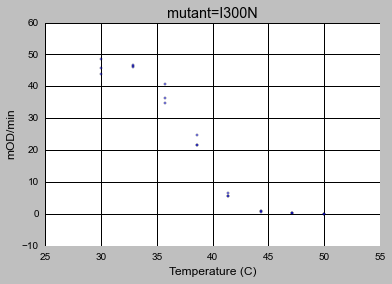

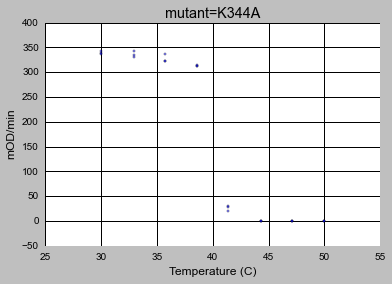

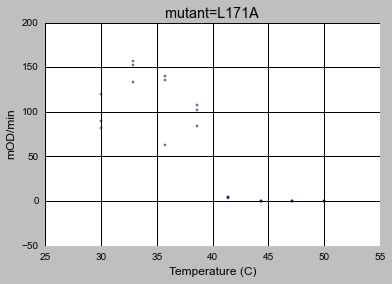

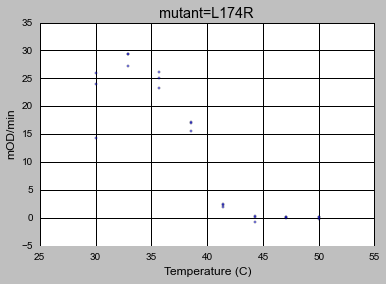

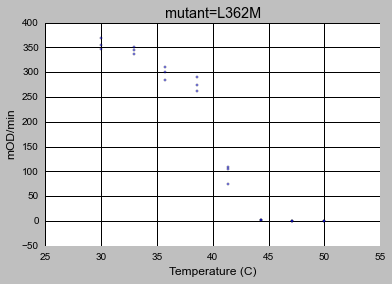

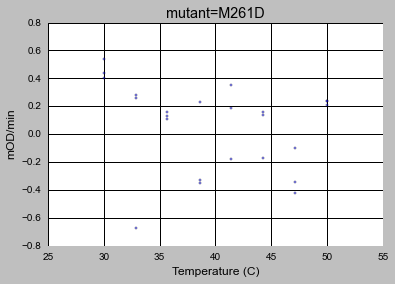

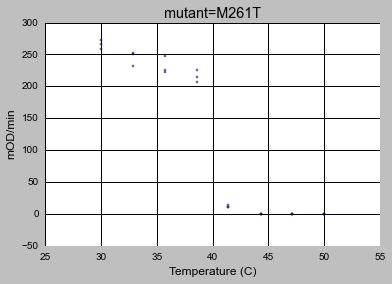

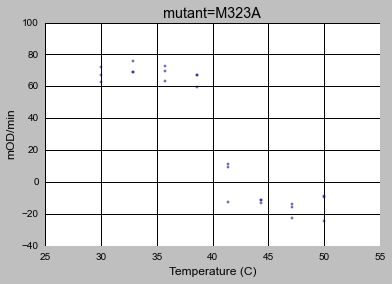

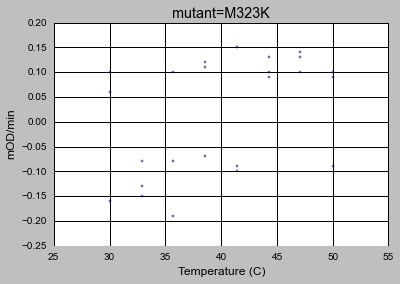

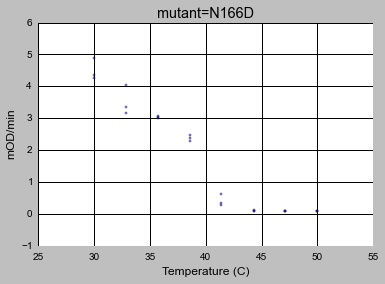

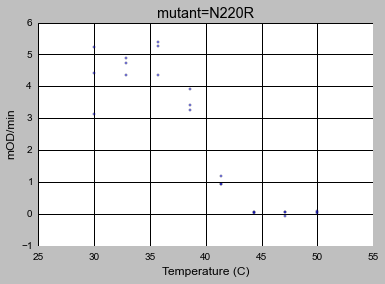

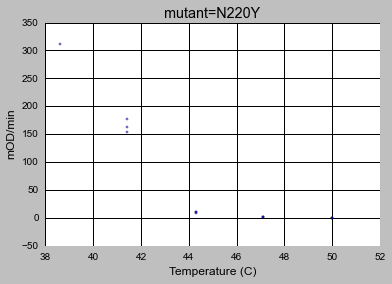

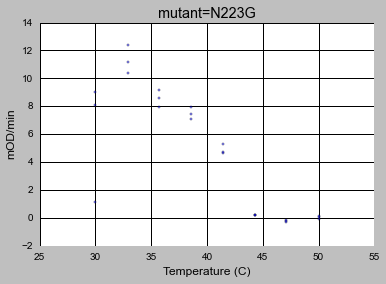

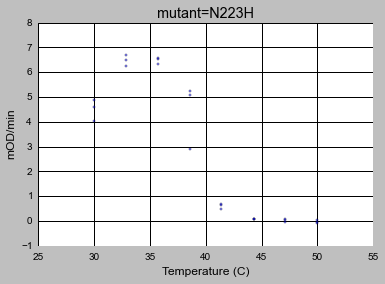

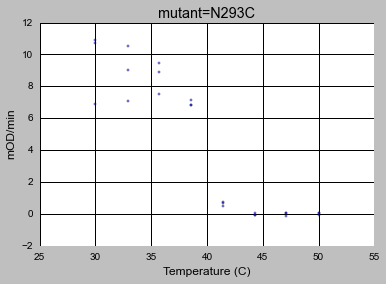

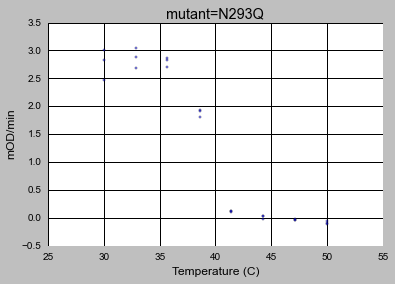

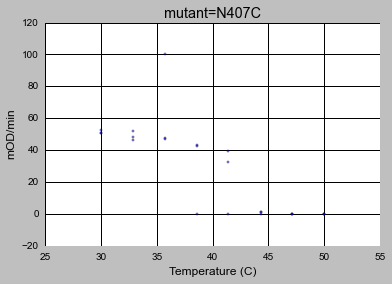

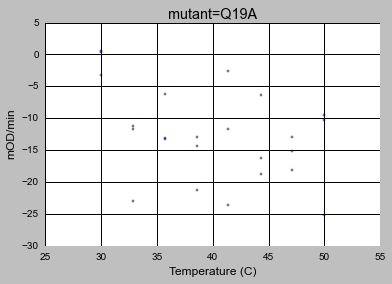

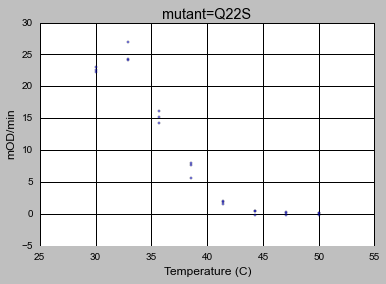

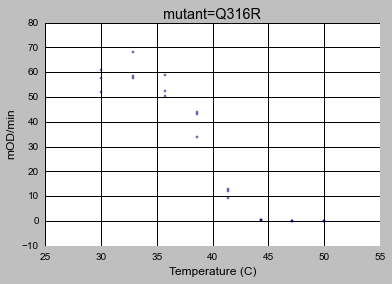

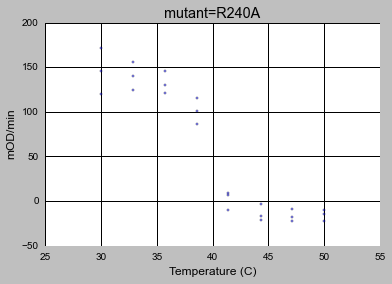

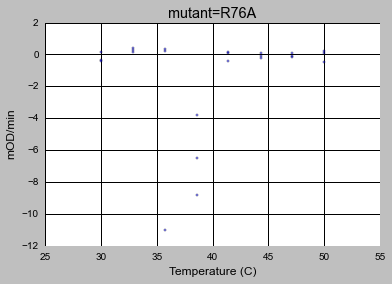

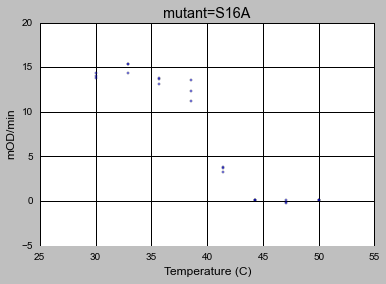

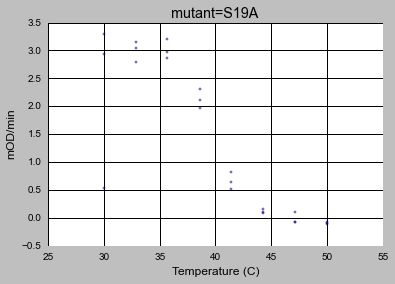

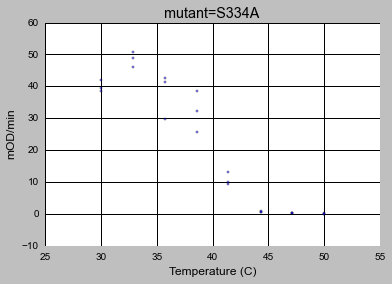

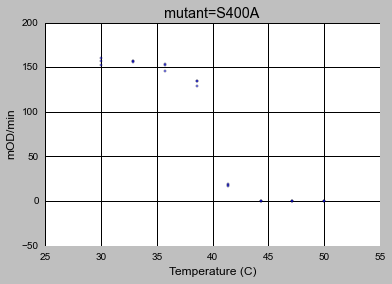

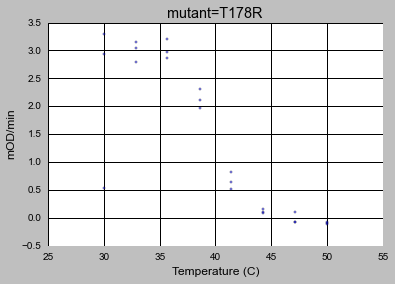

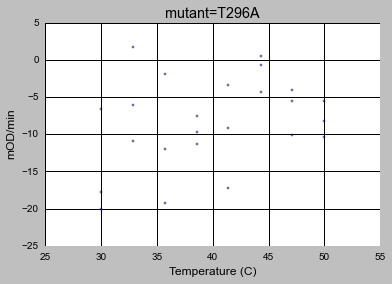

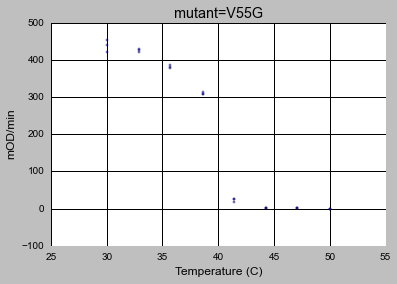

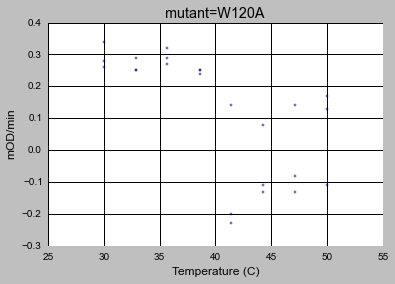

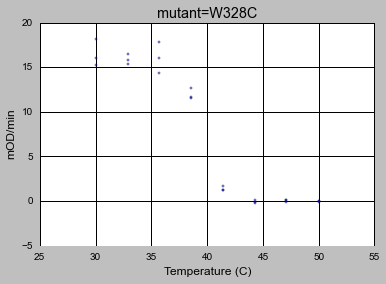

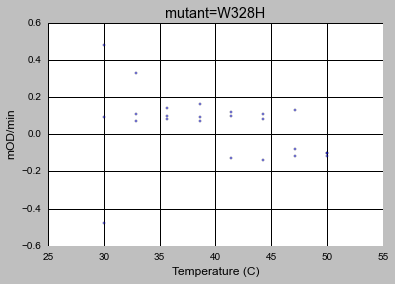

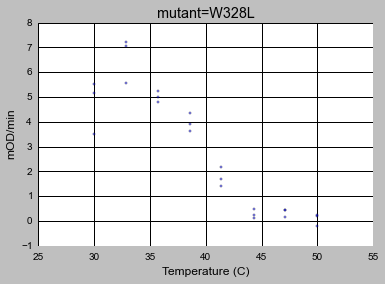

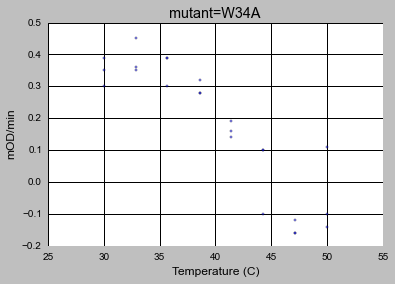

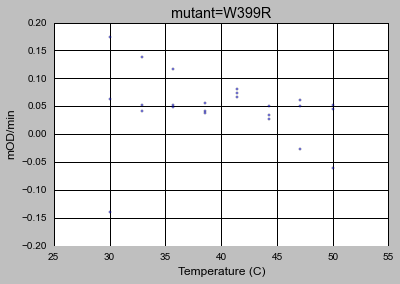

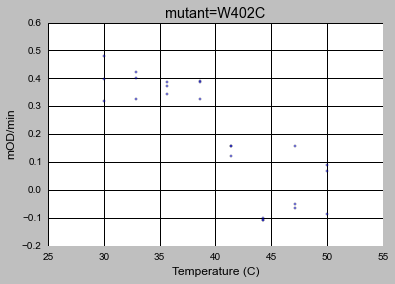

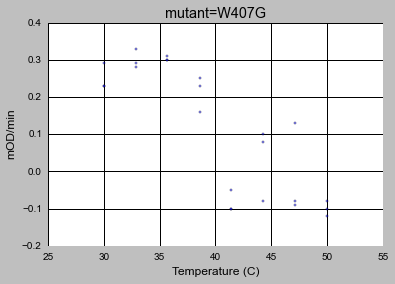

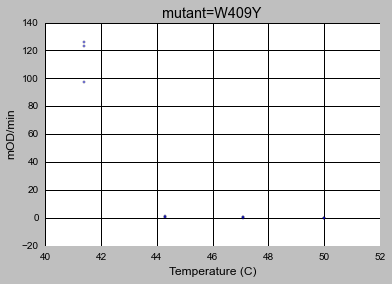

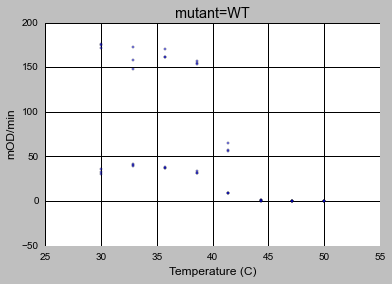

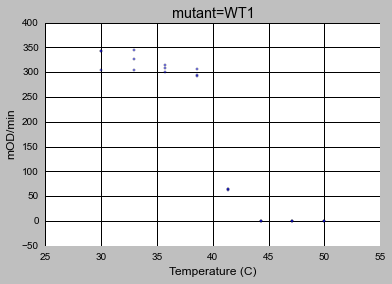

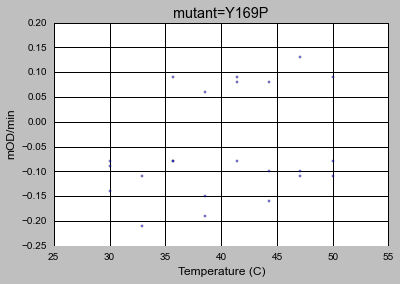

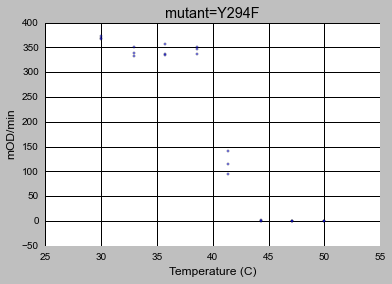

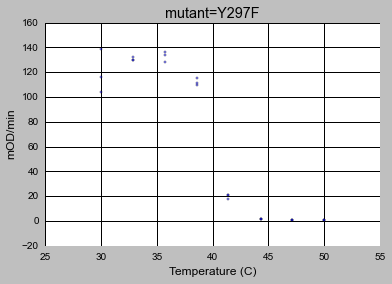

In [62]:
for name, d in grouped:
    plt.scatter( d.temp, d.rate*1000, alpha=0.5, marker='.' )
    plt.title( 'mutant={}'.format( name ) )
    plt.xlabel( 'Temperature (C)' )
    plt.ylabel( 'mOD/min' )
    plt.show()

# Thermostability of computationally-designed variants of β-glucosidase B

## Introduction 

The introduction of catalytic activity into existing enzyme scaffolds has been used for all successful enzyme designs to date. The choice of a suitable protein "scaffold" on which to design mutations is of paramount importance in the sucessful design of enzymes *de novo*. The redesign of existing catalytic proteins for new substrates is also hughly dependent on the inital starting point: the scaffold protein of a particular fold that is used to design mutations. 

The traditional dogma in the field of enzyme engineering is that thermostable proteins make the best scaffolds. They are said to possess intrinsic resistence to destabilizing effects of mutations. However, very few proteins have been systemically characterized for their ability to retain stability and activity when mutations are made across large portions of the protein. Thus, efforts to add data to the assertion that one should begin design efforts with a thermostable protein are necessary. Previous work provides a mounting body of evidence that the claim that protein design should process from thermostable scaffolds is mounting. The work of Brian Matthews on hundreds of point mutants of T7 lysozyme is a prime example: almost all of the point mutants retained their fold and were crystalized. Conversely, a 1998 paper on the stability of proteins at temperature above 100 C introduced a double mutation that increased thermostability about 8 fold. 

In this study, we functionally characterized over 100 single point mutants of β-glucosidase B from *P. polymxa* at various temperatures ranging from 30 C to 50 C via a colorimetric assay. We found that, contrary to the accepted dogma, point mutants of this enzyme did not differ in Tm from the wild type enzyme by more than X ± Y C. Out of 83 mutants assayed, we found a mean Tm of 40 ± 0.7 C within the range 37.6–41.4 C.

## Methods 

### Mutagenesis, protein production, and purification 

Plasmids containing designed point mutations were constructed by Kunkel mutagenesis and verified via Sanger sequencing. *Escherichia coli* BL21(DE3) cells were transformed and single colonies used to inoculate 5 mL cultures of Terrific Broth with 50 µg/mL kanamycin. After incubation for 24 hours at 37 C, cells were pelleted via centrifugation and resuspended in 5 mL Terrific Broth with 1 mM IPTG. After incubation at 18 C for 24 hours, His-tagged proteins were purified via immobilized metal ion chromotography, quantitated by absorbance at 280 nm and SDS-PAGE (see supplemental information for gel images and a complete table of protein yields). 

### Colorimetric assay 

Mutant proteins were incubated in a thermal cycler with a temperature gradient of 30–50 C in 2.5 C increments for 30 minutes prior to colorimetric assay where the rate of product formation was assesed by monitoring 420 nm every minute for 1 hour. Assay data were converted into rates (1/min) and fit to the logistic equation $$ v = \frac{L}{1+e^{-k(x-x_0)}} $$

where the rate $v$ is related to the maximum rate $L$, the kurtosis $k$ and the melting temperature $x_0$. 

## Results 

Measurements of the wild type enzyme fit to the logistic equation provide estimates of the melting temperature of 40.1 ± 0.88 C with a kurtosis of -1.3 ± 0.089 after a 30-minute incubation. 

## Discusion 

Enzyme design efforts have to date have preferentially used thermostable enzymes as a starting point for design, reasoning that mutations to already-stable proteins have adverse effects on protein stability. However, a growing body of evidence is beginning to overturn this view. 

In our study, the thermostability of over 100 single point mutants of β-glucosidase B from *P. polymxa* was determined via a colorimetric assay of the protein's function. On average, single point mutants differ in thermostability from the wild type enzyme less than 1 degree C. 

Our finding of relativly modest changes in thermostability from point mutations is consistent with previous work (Matthews) on the thermostability of T4 lysozyme, but thermostability data for a family 1 glycoside hydrolase has not been shown before. 